# GEO877: Spatial Algorithms - Haklay 



## Introduction

In this Jupyter Notebook we will replicate steps - and add upon some - taken within the paper by [Haklay](https://doi.org/10.1068/b35097) to compare volunteer geographic information to official geograpic data. For this we compare between [OpenStreetMap](https://www.openstreetmap.org/#map=9/46.8246/8.2245) (OSM) dataset and official datasets from the Swiss official bodies in our case [ASTRA](https://www.astra.admin.ch/astra/de/home.html).

We divide our approach into an assessement of Precision and Completeness, with precision checking for the Intersection between OSM highways and buffered ASTRA highway data. Further explanation and discussion of our approach is included in the report.


## Code structure
This main jupyter notebook code calls functions from adjacent jupyter notebooks:  
- Buffer.ipynb  
- segment_polygon_intersection.ipynb
- Similarity_Measures.ipynb
- geospatial.py

# Table of Contents

1. Initialization and Prerequisites  
    1.1 Classes and Functions  
    1.2 Datasets preprocessing  
        * OSM  
        * Swissdataset: Astra national roads  
        * Datasets exploration and comparison  
2. Positional accuracy  
    2.1 Buffer approach  
        * Buffer  
        * Intersection   
    2.2 Geometrical Similarity  
3. Completeness  

# 1. Initialization and Prerequisites

In [1]:
# Basic geometries from GEO877 with some custom Classes for Buffer
from geospatial import *

# Plotting, Arrays, Filepath handling and basic flattenning nested lists
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from itertools import chain

# Transformation of OSM data to projected CRS
from pyproj import Transformer

# OSM Part (and some selected apply() function calls)
import geopandas as gpd

# ASTRA Part (to load geodatabase)
import fiona

# Writing to results into pickles for caching between parts
import pickle

# For Preprocessing part - 
plot_steps = False
overwrite_pickles = True

## 1.1 Classes and Functions

In [2]:
# Define class to store attributes with each motorway segment
class MotorwaySegment(Segment):
    """
    MotorwaySegments class to store original data in Basic geometry form.
    In addition to base properties of geospatial.Segments following properties are defined:
    - name (str): Numeric string of custom name within our script. (e.g.: "1")
    - origin_name (str): Identifier/name in original data source (e.g.: "A1")
    - source (str): String corresponding to shortname used to declare origin (e.g.: "osm")
    - crs (str): String to identify Coordinate Reference System used as EPSG string (e.g.:'epsg:2056')
    """
    def __init__(self, start, end, name=str(), origin_name=str(), source=str(), crs=str()):
        # Initialize Segment superclass
        super().__init__(start, end)
        self.name = name
        self.origin_name = origin_name
        self.source = source
        self.crs = crs
    
    # Overwrite representation to include name of Segment
    def __repr__(self):
        return f'MotorwaySegment of "{self.name}" with start {self.start} and end {self.end}.' 
    
    def plot_seg(self, ax = None, color = 'blue', linewidth = 1, label = 'segments'):
        """
        Plots a segment as line within matplotlib.pyplot figure.
        """
        # List of x- and y- coordinates
        xs = [self.start.x, self.end.x]
        ys = [self.start.y, self.end.y]
        # Add to custom ax
        if ax:
            ax.plot(xs, ys, color = color, linewidth = linewidth, label=label)
        # Use default ax
        else:
            plt.plot(xs, ys, color = color, linewidth = linewidth, label=label)



In [6]:
class MotorwayLine():
    """
    MotorwayLine class - LineString-like object to store original data in Basic geometry form for whole highways.
    - segments (list): List of MotorwaySegment class objects
    - name (str): Numeric string of custom name within our script. (e.g.: "1"). Assumes all MotorwaySegments passed have the same name.
    - points (list): List of geospatial.Point objects
    - points_x (list): List of x-coordinates
    - points_y (list): List of y-coordinates
    """
    #initialise
    def __init__(self, data=None, xcol=None, ycol=None): #data = list of segments from the same street
        self.segments = []
        self.name = data[0].name
        self.points = []
        self.points_x = []
        self.points_y = []
        
        for d in data:
            #add segment
            self.segments.append(d)
            #add points - there will be duplicates /!\
            self.points.append(d.start)
            self.points.append(d.end)
            self.points_x.append(d.start.x)
            self.points_x.append(d.end.x)
            self.points_y.append(d.start.y)
            self.points_y.append(d.end.y)  
    
    def __len__(self):
        return len(self.segments)
    
        # Test for equality between Segments - we treat segments going in opposite directions as equal here
    def __eq__(self, other): 
        if (self.points_x == other.points_x or self.points_x[::-1] == other.points_x) and (self.points_y == other.points_y or self.points_y[::-1] == other.points_y) :
            return True
        else:
            return False
            
    # We need this method so that the class will behave sensibly in sets and dictionaries
    def __hash__(self):
        return hash((self.segments, self.points_x, self.points_y)) 
    
    def removeDuplicates(self, print_change=False):
        # Note: we could use inheritance within MotorwaySegments to remove duplicates
        # Copy of geospatial.Segment
        oldn = len(self.points)
        self.points = list(dict.fromkeys(self.points)) # Get rid of the duplicates
        n = len(self.points)
        if print_change:
            print(f'The old line had {oldn} points, now we only have {n}.')
        return self
        
    def bbox(self):
        # Copy of geospatial
        x = [i.x for i in self.points]   # extract all x coords as a list
        y = [i.y for i in self.points]   # extract all y coords as a list

        # determine corners, calculate centre and area
        self.ll = Point(min(x), min(y))    # lower-left corner (min x, min y)
        self.ur = Point(max(x), max(y))    # upper-right corner (max x, max y)
        self.ctr = Point((max(x)-min(x))/2, (max(y)-min(y))/2)   # centre of box
        self.area = (abs(max(x)-min(x)))*abs((max(y)-min(y)))    # area of box
        print(f'Bounding box with lower-left {self.ll} and upper-right {self.ur}' )
        return self.ll, self.ur
    
    def plot_bbox(self):
        """
        Plots bounding box of MotorwayLine in question in current axis.
        """
        ll, ur = self.bbox()
        plt.plot([ll.x, ll.x, ur.x, ur.x, ll.x], [ll.y, ur.y, ur.y, ll.y, ll.y], linestyle='dashed')

    def plot_seg(self, ax = None, color = 'blue', linewidth = 1, label = 'segments'):
        """
        Plots a segment as line within matplotlib.pyplot figure.
        """
        for seg in self.segments:
            seg.plot_seg(ax = ax, color = color, linewidth = linewidth, label = label)

        
     # Overwrite representation
    def __repr__(self):
        return f'MotorwayLine "{self.name}" has "{len(self.segments)}" segments, and "{len(self.points)}" points.'    


In [3]:
def name_mapping(in_name):
    """
    Single use function to map names of the OSM data to custom names e.g.: A1;A4 -> 1; A1 -> 1
    """
    #special cases, checked on QGIS:
    name_map = {"32": 1,
            "A1;A4": 1,
            "A1;A2": 1,
            "A1;A3": 1,
            "A1;A6": 1,
            "A1;A9": 1,
            "A9;A 2": 2,
            "A2;A3": 2,
            "A3;A4": 3,
            "53": 15,
            "A20;20": 20
           }
    if in_name in name_map.keys():
        return name_map[in_name]

    #correct cases:
    if ";" not in in_name:
        return int(''.join(filter(str.isdigit, in_name)))
    
    #catch new roads names
    else:
        print(in_name)
        print("Name not treated")

In [4]:
def linestring_to_motorwaysegment_list(ls_seg):
    name = ls_seg["name"]
    name_origin = ls_seg["ref"]
    source = ls_seg["source"]
    crs = ls_seg["crs"]
    point_list = tuple(Point(x,y) for x,y in zip(*ls_seg.geometry.coords.xy))
    if len(point_list) <=1:
        print("Cannot build MotorwaySegment from line with less than 2 points!")
        return
    else:
        segment_list = [MotorwaySegment(start, end, name, name_origin, source, crs) for start,end in zip(point_list[:-1],point_list[1:])]
        return segment_list

In [5]:
def transform_segment(segment, transformer, to_crs):
    start = segment.start
    end = segment.end
    name = segment.name
    source = segment.source
    crs = segment.crs
    start_transformed = transformer.transform(start.y, start.x)
    end_transformed = transformer.transform(end.y, end.x)
    transformed_segment = MotorwaySegment(Point(*start_transformed), Point(*end_transformed), name, source, to_crs)
    return transformed_segment

In [7]:
# Aim to add cell_index column
# =====
class CellSegment(MotorwaySegment):
    def __init__(self, motorwaysegment, precision=2):
        # Copy attributes from motorwaysegment
        self.__dict__ = motorwaysegment.__dict__.copy()
        # Add additional attributes
        self.index1 = 0
        self.index2 = 0
        self.precision = precision
        self.set_precision(precision)
    
    def set_precision(self,n_significant_digit=None):
        self.start.x = round(self.start.x, n_significant_digit)
        self.start.y = round(self.start.y, n_significant_digit)
        self.end.x = round(self.end.x, n_significant_digit)
        self.end.y = round(self.end.y, n_significant_digit)
        self.precision = n_significant_digit
        return
    
    def __repr__(self):
        return f'CellSegment of "{self.name}" with start {self.start} and end {self.end}, start cell in {self.index1} and end cell in {self.index2}.'
    

In [8]:
# Aim to package all the related variables and functions to one class
# =====
class CellLength():
    def __init__(self, data, box, res, precision=2):
        self.data = data
        # Number of grid rows and colums
        self.res = res #res = resolution
        self.precision = precision
        self.w = box.ur.x - box.ll.x
        self.h = box.ur.y - box.ll.y
        self.nCols = int(self.w/ self.res)+1
        self.nRows = int(self.h/ self.res)+1
        
        ur = Point(box.ll.x + (self.nCols * self.res), box.ll.y + (self.nRows * self.res))
        ll = box.ll
        self.bBox = Bbox([ll, ur])
        
        # Cell with index to store the length
        self.maxIndex = (self.nCols * self.nRows) -1        
        # Use a NumPy array instead of a list to store cellLength data (float16 to constrain memory use)
        self.cellLength = np.zeros(self.maxIndex + 1, dtype=np.float16)
            
    def addIndex(self):
        for segment in self.data:
            segment.index1 = self.pointIndex(segment.start)  # add index of start point
            segment.index2 = self.pointIndex(segment.end)  # add index of end point   
    
    def pointIndex(self, p): # Define the which cell the point is in
        j = int((p.y - self.bBox.ll.y)/ self.res)
        i = int((p.x - self.bBox.ll.x)/ self.res)
        return (j * self.nCols) + i    
    
    def addLength(self):
        self.addIndex()

        self.length = 0
        self.seg_ab = []

        for seg in self.data:
            seg_length = self.segLength(seg.start, seg.end)
            if seg.index1 == seg.index2: # if in the same cell
                index = seg.index1
                self.cellLength[index] += seg_length
                self.length += seg_length
            else:
                point1 = seg.start
                point2 = seg.end
                index1 = seg.index1
                index2 = seg.index2

                j1 = int((point1.y - self.bBox.ll.y) / self.res)
                i1 = int((point1.x - self.bBox.ll.x) / self.res)
                j2 = int((point2.y - self.bBox.ll.y) / self.res)
                i2 = int((point2.x - self.bBox.ll.x) / self.res)

                min_i = min(i1,i2)
                max_i = max(i1,i2)
                min_j = min(j1,j2)
                max_j = max(j1,j2)

                points = [point1, point2]

                if point1.x == point2.x:
                    # Handle vertical line segment
                    while min_j < max_j: 
                        intersect_y = (min_j + 1)*self.res + self.bBox.ll.y 
                        intersect_x = point1.x
                        point_new = Point(intersect_x,intersect_y)
                        points.append(point_new)
                        min_j += 1
                elif point1.y == point2.y:
                    # Handle horizontal line segment
                    while min_i < max_i: 
                        intersect_x = (min_i + 1)*self.res + self.bBox.ll.x 
                        intersect_y = point1.y
                        point_new = Point(intersect_x,intersect_y)
                        points.append(point_new)
                        min_i += 1
                else:
                    k = (point2.y - point1.y)/(point2.x - point1.x)
                    b =  point1.y - (k * point1.x)

                    while min_j < max_j: 
                        intersect_y = (min_j + 1)*self.res + self.bBox.ll.y 
                        intersect_x = (intersect_y - b)/k
                        point_new = Point(intersect_x,intersect_y)
                        points.append(point_new)
                        min_j += 1

                    while min_i < max_i: 
                        intersect_x = (min_i + 1)*self.res + self.bBox.ll.x
                        intersect_y = k*intersect_x + b
                        point_new = Point(intersect_x,intersect_y)
                        points.append(point_new)
                        min_i += 1

                # Sort points by x-coordinate
                points.sort(key=lambda p: p.x)

                # Calculate length
                for i in range(len(points)-1):
                    start = points[i]
                    end = points[i+1]
                    seg_cellindex = self.pointIndex(points[i+1])
                    length = self.segLength(start, end)
                    self.cellLength[seg_cellindex] += round(length, self.precision)

    def segLength(self,p1,p2):  # calculate segment length
        return p1.distEuclidean(p2) 
    

In [9]:
def write_to_pickle(variable, filename):
    with open(filename, 'wb') as f:
        pickle.dump(variable, f)

def read_from_pickle(filename):
    with open(filename, 'rb') as f:
        variable = pickle.load(f)
    return variable

## 1.2 Datasets preprocessing

### OSM

#### Download data

In [10]:
# Define Filepath and OSM tags
tags = {"highway":"motorway"}
motorway_file_path = Path(r"./data/motorways_osm.geojson")

# Download OSM Data to GeoDataFrame() if GeoJSON does not exist
if motorway_file_path.is_file():
    motorways = gpd.read_file(motorway_file_path)
else:
    # Needs special requirements for shapely, geopandas and other packages /!\
    # Use ox package to download geometries from
    import osmnx as ox
    motorways = ox.geometries_from_place("Switzerland",tags=tags)
    # Convert lists to strings for GeoJSON
    motorways = motorways.apply(lambda col: col.astype(str) if isinstance(col[0], list) else col)
    motorways.to_file(motorway_file_path, "GeoJSON")

if plot_steps:
    motorways.plot()

#### Data filtering
To have the same data as in ASTRA, some filter has to be applied.

Some highways collected in OSM are not taken care by ASTRA, but by cantons. They are therefore not in ASTRA datasets and were discarded ("A50" and "A51").
Subsections of the highway "A1" ("A1a", "A1H", "A1R", "A1L", "A3W"), are not represented in the ASTRA data, and were therefore discarded.  
"A24" was also discarded as it is a road feeder and was normally not represented in OSM like the other road feeders.


In [11]:
#Remove unwanted segments and remove NA
discard_list = ["A1a", "A1H", "A1R","A1R;5", "A1L", "A3W", "A24", "A50", "7;A50", "A51"]
filter_osm = ~motorways.ref.isin(discard_list)
motorways = motorways[filter_osm]
motorways = motorways[motorways['ref'].notna()]


#### Convert LineString() to list of MotorwaySegment()

In [12]:
mway = motorways.copy()
mway["geometry"] = mway.geometry.explode(index_parts=False)
mway["source"] = "osm"
mway["crs"] = 'epsg:4326'
mway["name"] = mway['ref'].apply(name_mapping)

mway["segments"] = mway.apply(linestring_to_motorwaysegment_list, axis=1)
mway = mway.explode("segments", index_parts=False)
mway = mway.reset_index()

#### Transform from EPSG:4326 to EPSG:2056

In [13]:
# Example 4326 to 2056
from_crs = 'epsg:4326'
to_crs = 'epsg:2056'

transformer = Transformer.from_crs(from_crs, to_crs)
motorway_segments_transformed = mway["segments"].apply(transform_segment, transformer=transformer, to_crs=to_crs)
if plot_steps:
    print(f"{mway['segments'][0]} {mway['segments'][0].crs}",
          f"{motorway_segments_transformed[0]} \t {motorway_segments_transformed[0].crs}",
          sep="\n")

#### Roads renaming
As OSM data is not rigorious, some corrections had to be made on the name registered. Visual data inspection was required for some cryptic names ("32", "52", "nan", ...). Then, only the number of the road has been kept.  
Example of corrections: "A 12" -> "A12", "A10;7" -> "A10", "53" -> "A15".


In [14]:
if plot_steps:
    streetnames_osm_toclean = motorways.ref.unique()

    print(streetnames_osm_toclean)
    print(len(streetnames_osm_toclean))

    # Test/showcase only (not needed in main script)
    #build streetnames_osm list
    streetnames_osm = list(set(name_mapping(street) for street in streetnames_osm_toclean))

    print(sorted(streetnames_osm))
    print(len(streetnames_osm))

#### Class MotorwayLine

In [15]:
# Create Lookup dictionary with Segments by segment name (1:[MotorwaysSegment,...],2:[],...)
segments_by_name = {}
for segment in motorway_segments_transformed:
    if segment.name not in segments_by_name:
        segments_by_name[segment.name] = []
    segments_by_name[segment.name].append(segment)

streetnames_osm = motorway_segments_transformed.apply(lambda x: x.name).unique()
motorway_osm_lines = []
for streetname in streetnames_osm:
    # Use streetname to retrieve list of segments
    list_segments = segments_by_name.get(streetname, [])
    if list_segments:
        motorwayLine = MotorwayLine(list_segments)
        motorway_osm_lines.append(motorwayLine)

motorway_osm_lines = sorted(motorway_osm_lines, key=lambda x: x.name)

if plot_steps:
    print(motorway_osm_lines[0])
    print(motorway_osm_lines[0].segments[0].origin_name)
    len(motorway_osm_lines)

#### Data exploration

In [16]:
if plot_steps:
    motorway_osm_lines[0].segments[0:10]

In [17]:
if plot_steps:
    # PLOT FROM ORIGINAL GEOMETRY
    print(len(motorways[motorways["ref"]=="A2"]))
    motorways[motorways["ref"]=="A2"].plot()

In [18]:
if plot_steps:
    # PLOT A1
    print(motorway_osm_lines[1])
    motorway_osm_lines[1].removeDuplicates(print_change=True)
    motorway_osm_lines[1].plot_bbox()
    motorway_osm_lines[1].plot_seg()

### Swissdataset: Astra national roads

#### Download data
Download data from:  
https://data.geo.admin.ch/browser/index.html#/collections/ch.astra.nationalstrassenachsen/items/nationalstrassenachsen?.language=en&.asset=asset-nationalstrassenachsen_2056.gdb.zip 


In [19]:
#import .gdb
fiona.listlayers(Path(r"data/national_roads/ch.astra.nationalstrassenachsen.gdb"))
motorways_ch = gpd.read_file(Path(r"data/national_roads/ch.astra.nationalstrassenachsen.gdb"), driver='FileGDB', layer='Stammachsen')
if plot_steps:
    motorways_ch.plot()

In [20]:
if plot_steps:
    #visualize first 3 rows
    motorways_ch[0:3]

#### Data filtering
The federal roads office ASTRA [[1]](https://www.astra.admin.ch/astra/fr/home/themes/routes-nationales/reseau.html) is responsible for the national roads, i.e. the most important roads for Switzerland. Therefore ASTRA datasets do not only include highways, but also main roads.   
To sort national roads, a visual inspection of both datasets (OSM and ASTRA) was made on QGIS. This helped discovering that one of the attributes in ASTRA dataset could be used as a filter:
- Positionscode "=".  
"=" indicates that this is a one way road, which correlates with not being a highway, therefore not present in OSM dataset with the tag "highway".  
8 national roads were removed entirely this way (N1BAR, N2BEL, N2P, N17, N24, N25, N28 and N29).
Excepted for N24 (feeder road), which was removed even though it was also on OSM, this proved to be an efficient and quick filter.  
Out of 28 national roads, 20 then remained.

In addition, to crossvalidate the results, the following ressources have been used:  
- [autobahnen.ch](https://www.autobahnen.ch/).
- [Wiki page: List of the swiss national roads](https://de.wikipedia.org/wiki/Liste_der_Nationalstrassen_der_Schweiz)
- [Wiki page: List of the swiss highways and motorroads](https://de.wikipedia.org/wiki/Liste_der_Autobahnen_und_Autostrassen_in_der_Schweiz)

Astra dataset is unfortunately poorly documented online, therefore wikipedia was a useful source.

[[1]]: https://www.astra.admin.ch/astra/fr/home/themes/routes-nationales/reseau.html

#### Renaming of the roads
National roads numbers (N1 -> N...) correspond with highways numbers (A1 -> A...), therefore the renaming contained only the number.

In [21]:
# Remove positionscode
filt_equal = motorways_ch["Positionscode"] != "="
motorways_ch = motorways_ch.copy().loc[filt_equal]

In [22]:
# Extract streetname and convert to int
motorways_ch.loc[:, 'streetname'] = motorways_ch['Strassennummer'].str.extract(r'(\d+)').astype(int)

streetnames_ch = motorways_ch['streetname'].unique()
if plot_steps:
    print(sorted(streetnames_ch))
    print(len(streetnames_ch))

#### Class MotorwaySegment

In [23]:
mway_ch = motorways_ch.copy()
mway_ch["geometry"] = mway_ch.geometry.explode(index_parts=False)
mway_ch["source"] = "astra"
mway_ch["crs"] = 'epsg:2056'
mway_ch["name"] = mway_ch['streetname']
mway_ch["ref"] = mway_ch["Strassennummer"]

mway_ch['segments'] = mway_ch.apply(linestring_to_motorwaysegment_list, axis=1)
mway_ch = mway_ch.explode("segments", index_parts=False)
mway_ch = mway_ch.reset_index()

#### Class MotorwayLine

In [24]:
segments_by_name = {}
for segment in mway_ch['segments']:
    if segment.name not in segments_by_name:
        segments_by_name[segment.name] = []
    segments_by_name[segment.name].append(segment)

motorway_ch_lines = []
for streetname in streetnames_ch:
    list_segments = segments_by_name.get(streetname,[])
    if list_segments:
        motorwayLine = MotorwayLine(list_segments)
        motorway_ch_lines.append(motorwayLine)

motorway_ch_lines = sorted(motorway_ch_lines, key=lambda x: x.name)

if plot_steps:
    print(motorway_ch_lines[1])
    print(motorway_ch_lines[1].segments[1].origin_name)
    len(motorway_ch_lines)

### Datasets exploration and comparison

#### Write MotorwayLine to Pickle

In [25]:
# TODO
# motorway_ch_lines to Pickle
write_to_pickle(motorway_osm_lines, "motorway_osm_lines.pkl")
write_to_pickle(motorway_ch_lines, "motorway_ch_lines.pkl")

#### Data exploration

In [26]:
for motorway in motorway_ch_lines:
    if motorway.name == 2:
        N2 = motorway

if plot_steps:
    N2.segments[0:10]

In [27]:
if plot_steps:
    # PLOT A2 FROM ORIGINAL GEOMETRY
    print(len(motorways_ch[motorways_ch["Strassennummer"] == "N2"]))
    motorways_ch[motorways_ch["Strassennummer"] == "N2"].plot()

In [28]:
if plot_steps:
    # PLOT A2 FROM MOTORWAY LINES
    print(N2)
    N2.removeDuplicates(print_change=True)
    N2.plot_bbox()
    N2.plot_seg()

#### Comparison of the motorway lines

In [29]:
if plot_steps:
    print(sorted(streetnames_osm))
    print(sorted(streetnames_ch))
    print(len(streetnames_osm))

In [30]:
if plot_steps:
    fig, axs = plt.subplots(5, 4, figsize=(12, 12))
    for i in range(5): #5
        for j in range(4): #4
            index = i * 4 + j
            motorway_ch_lines[index].plot_seg(ax = axs[i, j], label="ASTRA", color = "blue", linewidth = 5)
            motorway_osm_lines[index].plot_seg(ax = axs[i, j], label="OSM", color = "red")
            axs[i, j].set_title(f'A{motorway_osm_lines[index].name}')
            axs[i,j].set_aspect('equal', adjustable='datalim')

    # Affichage de la figure
    plt.tight_layout()
    plt.show()
    #fig.savefig("plots/osm_astra_comparison.png")

In [31]:
#Stitching together code snippets
import nbimporter
from Buffer import buffer
from Segment_Polygon_Intersection_AlgorithmsOnly_MoreExplained_updated import *
from Similarity_Measures import dtw


# 2. Positional accuracy

## 2.1 Buffer approach

### Buffering MotorwayLines

In [32]:
from Buffer import buffer

In [33]:
### FUNCTION FROM CHAT GPT ###
def simplify_points(points_list, epsilon):
    result = []
    for points in points_list:
        simplified_points = [points[0]]
        for i in range(1, len(points)):
            x1, y1 = simplified_points[-1].x, simplified_points[-1].y
            x2, y2 = points[i].x, points[i].y
            if sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2) > epsilon:
                simplified_points.append(points[i])
        result.append(simplified_points)
    return result

In [34]:
astra = read_from_pickle("motorway_ch_lines.pkl")
osm = read_from_pickle("motorway_osm_lines.pkl")

list_unique_points_astra = simplify_points([mw_line.removeDuplicates(print_change=False).points for mw_line in astra], 99)
#buffered_astra = buffer(nodes=list_unique_points_astra[0], dist=10, nn=20, reduction=50)
buffered_astra = list(map(lambda points: buffer(nodes=points, dist=100, nn=3, reduction=25), list_unique_points_astra[:2]))
write_to_pickle(buffered_astra, "buffered_astra.pkl")

In [35]:
list_unique_points_osm = [mw_line.removeDuplicates(print_change=False).points for mw_line in osm]
buffered_osm = list(map(lambda points: buffer(nodes=points, dist=100, nn=3, reduction=50), list_unique_points_osm[:2]))
write_to_pickle(buffered_osm, "buffered_osm.pkl")

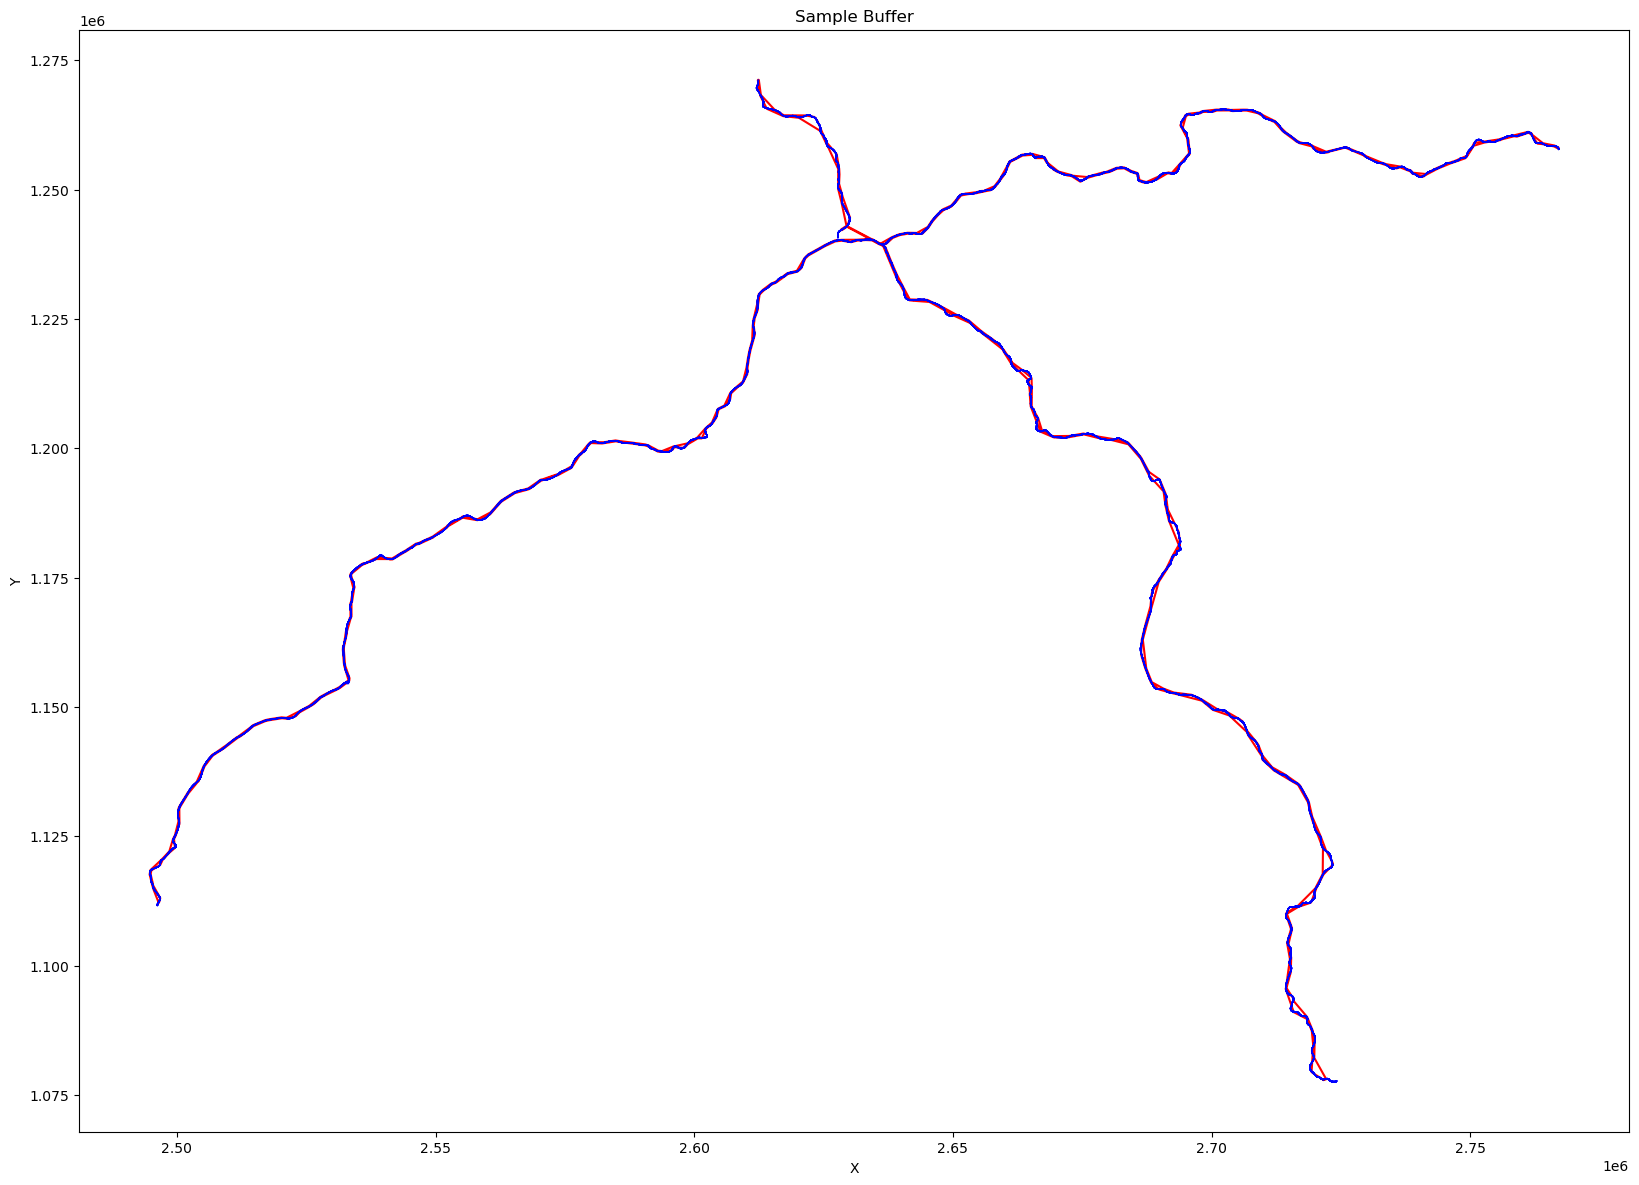

In [36]:
fig, ax0 = plt.subplots(figsize = (20,20))

buffered_astra_segments = [[p1,p2] for p1,p2 in zip(buffered_astra[0], buffered_astra[1])]
buffered_osm_segments = [[p1,p2] for p1,p2 in zip(buffered_osm[0], buffered_osm[1])]


for polygon in buffered_astra:
    ax0.plot([p.x for p in polygon.points],
             [p.y for p in polygon.points], color = 'red')
    
for mwayline in motorway_ch_lines[:2]:
    mwayline.removeDuplicates(print_change=False).plot_seg(ax=ax0, color="blue")

#for polygon in buffered_osm:
#    ax0.plot([p.x for p in polygon.points],
#             [p.y for p in polygon.points], color = 'blue')

ax0.set_xlabel('X')
ax0.set_ylabel('Y')
ax0.set_title('Sample Buffer')
ax0.set_aspect('equal')

### Intersection Buffer Geometries

In [37]:
# Load points in array([[]])
motorway_ch_lines = read_from_pickle("motorway_ch_lines.pkl")
motorway_osm_lines = read_from_pickle("motorway_osm_lines.pkl")
buffered_astra = read_from_pickle("buffered_astra.pkl")
buffered_osm = read_from_pickle("buffered_osm.pkl")


In [38]:
osm_segs = [seg for seg in chain(*[mw_line.segments for mw_line in motorway_osm_lines[:2]])]

In [52]:
inter = inter_multi_seg_pol(seg_g=osm_segs, pol_g=buffered_astra)
inter/sum([seg.length for seg in osm_segs])

[[ 0.          0.        ]
 [51.71735869  0.        ]
 [ 0.          0.        ]
 ...
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.         19.32985   ]]


0.02513673989196327

[[ 0.          0.        ]
 [51.71735869  0.        ]
 [ 0.          0.        ]
 ...
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.         19.32985   ]]


0.02513673989196327

## 2.2 Geometrical Similarity

In [53]:
# Load points in array([[]])
motorway_ch_lines = read_from_pickle("motorway_ch_lines.pkl")
motorway_osm_lines = read_from_pickle("motorway_osm_lines.pkl")
buffered_astra = read_from_pickle("buffered_astra.pkl")
buffered_osm = read_from_pickle("buffered_osm.pkl")

In [54]:
similarities = []
for i in range(0,2):
    # [Point1(), Point2(), Point3(),...]
    osm_sorted_point_list = sorting_PointGroup([point for point in motorway_osm_lines[i].points])
    astra_sorted_point_list = sorting_PointGroup([point for point in motorway_ch_lines[i].points])
    
    osm_coord_lists = [[point.x, point.y] for point in osm_sorted_point_list][::5]
    astra_coord_lists = [[point.x, point.y] for point in astra_sorted_point_list][::5]
    similarities.append(dtw(osm_coord_lists, astra_coord_lists))
    
    # Check if results with the same coords is correct (it is ;))
    #similarities.append(dtw(osm_coord_lists, osm_coord_lists))

In [55]:
similarities

[(1125776.3878317578,
  array([[1.68212727e+01, 2.38741328e+01, 5.50070355e+01, ...,
          1.48032453e+09, 1.48063059e+09, 1.48093665e+09],
         [9.22491225e+01, 7.14270105e+01, 5.31527276e+01, ...,
          1.47997201e+09, 1.48027804e+09, 1.48058408e+09],
         [1.94165411e+02, 1.94211924e+02, 2.01595025e+02, ...,
          1.47997209e+09, 1.48027812e+09, 1.48058415e+09],
         ...,
         [1.01497515e+09, 1.01487779e+09, 1.01475418e+09, ...,
          1.12699709e+06, 1.12754315e+06, 1.12809035e+06],
         [1.01528120e+09, 1.01518383e+09, 1.01506020e+09, ...,
          1.12552234e+06, 1.12598251e+06, 1.12644372e+06],
         [1.01558728e+09, 1.01548990e+09, 1.01536626e+09, ...,
          1.12492563e+06, 1.12535057e+06, 1.12577639e+06]])),
 (17536720.538645186,
  array([[4.49676719e+00, 9.47120766e+00, 1.53390926e+01, ...,
          8.17514835e+08, 8.17737068e+08, 8.17959294e+08],
         [3.46508378e+01, 4.09285067e+01, 3.93054735e+01, ...,
          8.17514863e+

[(1125776.3878317578,
  array([[1.68212727e+01, 2.38741328e+01, 5.50070355e+01, ...,
          1.48032453e+09, 1.48063059e+09, 1.48093665e+09],
         [9.22491225e+01, 7.14270105e+01, 5.31527276e+01, ...,
          1.47997201e+09, 1.48027804e+09, 1.48058408e+09],
         [1.94165411e+02, 1.94211924e+02, 2.01595025e+02, ...,
          1.47997209e+09, 1.48027812e+09, 1.48058415e+09],
         ...,
         [1.01497515e+09, 1.01487779e+09, 1.01475418e+09, ...,
          1.12699709e+06, 1.12754315e+06, 1.12809035e+06],
         [1.01528120e+09, 1.01518383e+09, 1.01506020e+09, ...,
          1.12552234e+06, 1.12598251e+06, 1.12644372e+06],
         [1.01558728e+09, 1.01548990e+09, 1.01536626e+09, ...,
          1.12492563e+06, 1.12535057e+06, 1.12577639e+06]])),
 (17536720.538645186,
  array([[4.49676719e+00, 9.47120766e+00, 1.53390926e+01, ...,
          8.17514835e+08, 8.17737068e+08, 8.17959294e+08],
         [3.46508378e+01, 4.09285067e+01, 3.93054735e+01, ...,
          8.17514863e+

# 3. Completeness

In [56]:
# The rest is in "main()"

# bBox and res (bBox is fixed, user can change res value)
xs = 2250000
xf = 3000000
ys = 1075000
yf = 1300000
box = Bbox([Point(xs, ys), Point(xf, yf)])
res = 100 # can change
precision = 2 #2: [cm], 3: [mm]

In [57]:
motorway_osm_lines = read_from_pickle("motorway_osm_lines.pkl")
motorway_osm_segments = list(chain(*map(lambda x: x.segments, motorway_osm_lines)))

In [58]:
#%%timeit -n 1
# osm dataset: 
cellSegments_osm = [CellSegment(segment,precision) for segment in motorway_osm_segments]
cellLength_osm = CellLength(cellSegments_osm, box, res)
cellLength_osm.addIndex()
cellLength_osm.addLength()
cellLength_osm.cellLength

array([0., 0., 0., ..., 0., 0., 0.], dtype=float16)

array([0., 0., 0., ..., 0., 0., 0.], dtype=float16)

In [60]:
motorway_ch_lines = read_from_pickle("motorway_ch_lines.pkl")
motorway_ch_segments = list(chain(*map(lambda x: x.segments, motorway_ch_lines)))

In [61]:
# Astra dataset:
cellSegments_astra = [CellSegment(segment,precision) for segment in motorway_ch_segments]
    
cellLength_astra = CellLength(cellSegments_astra, box, res)
cellLength_astra.addIndex()
cellLength_astra.addLength()
# Astra result
cellLength_astra.cellLength

array([0., 0., 0., ..., 0., 0., 0.], dtype=float16)

array([0., 0., 0., ..., 0., 0., 0.], dtype=float16)

In [62]:
# Comparison V3 (to increase resolution)
# Convert result1 and result2 to NumPy arrays
result1 = np.array(cellLength_osm.cellLength).round(precision)
result2 = np.array(cellLength_astra.cellLength).round(precision)

# Create a mask to select only the non-zero elements of result1 and result2
mask = (result1 != 0) & (result2 != 0)

# Exclude elements of result2 that are equal to zero
mask &= (result2 != 0)

# Compute result array using vectorized operations
result = np.full_like(result1, -1, dtype=np.float32)
np.divide(result1, result2, out=result, where=mask)
result *= 100
np.clip(result, -1, 100, out=result)

# Create a 2D array with shape (cellLength.nCols, cellLength.nRows)
a = result.reshape(cellLength_osm.nRows, cellLength_osm.nCols).T

print(a)

[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


Mean: 86.12786102294922
Median: 100.0


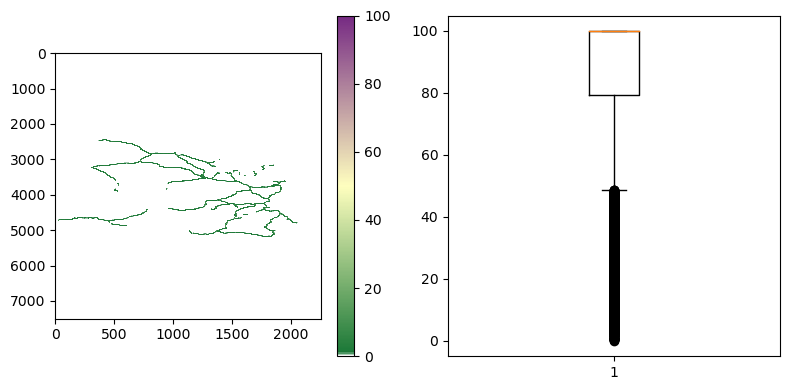

Mean: 86.12786102294922
Median: 100.0


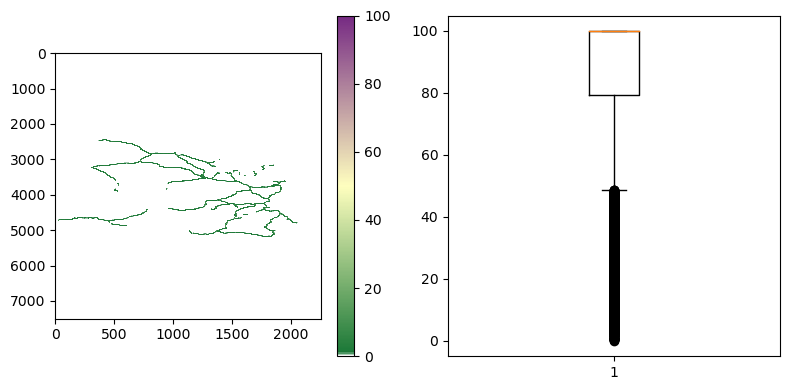

In [63]:
from matplotlib.colors import LinearSegmentedColormap

# Create a custom colormap
colors = [(0, 'white'), (0.01, '#1b7837'), (0.5, "#ffffbf"), (1, '#762a83')]
cmap = LinearSegmentedColormap.from_list('custom', colors)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
non_zero_a = a[a>=0]


# Display the array as an image
ratio = a.shape[1]/a.shape[0]
im = axs[0].imshow(a, aspect=ratio, cmap=cmap, vmin=0, vmax=100)
fig.colorbar(im, ax=axs[0])

# Statistics
axs[1].boxplot(non_zero_a)
print(f"Mean: {np.mean(non_zero_a)}")
print(f"Median: {np.median(non_zero_a)}")

plt.tight_layout()
plt.show()

(array([  191.,   300.,   350.,   393.,   533.,   727.,   978.,  1329.,
         1791., 12259.]),
 array([2.92062759e-02, 1.00262852e+01, 2.00233650e+01, 3.00204449e+01,
        4.00175247e+01, 5.00146027e+01, 6.00116806e+01, 7.00087585e+01,
        8.00058441e+01, 9.00029221e+01, 1.00000000e+02]),
 <BarContainer object of 10 artists>)

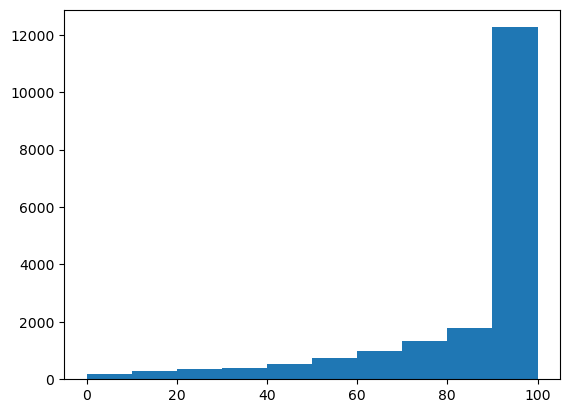

In [50]:
plt.hist(non_zero_a)

In [51]:
import rasterio
from rasterio.transform import from_origin

# Set geotransform
xs = 2250000
xf = 3000000
ys = 1075000
yf = 1300000

transform = from_origin(xs/res, ys/res, xf/res, yf/res)

# Set CRS
crs = {'init': 'epsg:2056'}

# Write array to file
with rasterio.open('result_completeness.tif', 'w', driver='GTiff', height=a.shape[1],
                   width=a.shape[0], count=1, dtype=a.dtype,
                   crs=crs, transform=transform) as dst:
    dst.write(a, 1)